# LULC Classification with CNN

In [1]:
import rasterio
import rasterio.plot
from rasterio.mask import mask
import matplotlib.pyplot as plt

import geopandas as gpd
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

RNG_SEED = 42

In [37]:
# Optional - Used to play sound when slow cells are finished executing
from IPython.display import Audio
import numpy as np

## Data Import

In [2]:
full_image_path = "2_CNN/input/aerial.tif"  # Aerial raster of entire area to be classified
labels_aerial_path = "2_CNN/input/aerial_512.tif" # Aerial raster of just labelled data
labels_classes_path = "2_CNN/input/labels_raster_512.tif" # Class raster of labelled data

In [38]:
# Load Full Image Aerial
with rasterio.open(full_image_path) as src:
    full_image = src.read()  # Read all bands
    full_image_meta = src.profile

# Load Classes Raster of Labelled Sample
with rasterio.open(labels_classes_path) as src:
    labels_classes = src.read(1)  # Read the first (or only) band
    labels_classes_meta = src.profile

# Load Aerial Raster of Labelled Sample
with rasterio.open(labels_aerial_path) as src:
    labels_aerial = src.read()
    labels_aerial_meta = src.profile

# Normalize image
full_image = full_image.astype(np.float32) / 255.0  # Normalize to 0-1 range if needed

# Print shapes
print("Full Image shape:", full_image.shape)  # Should be (Bands, Height, Width)
print("Labels Aerial shape:", labels_aerial.shape)
print("Labels Classes shape:", labels_classes.shape)  # Should be (Height, Width)

Full Image shape: (3, 2347, 2560)
Labels Aerial shape: (3, 512, 512)
Labels Classes shape: (512, 512)


#### ***Optional:*** *Visualize full aerial and labelled data*

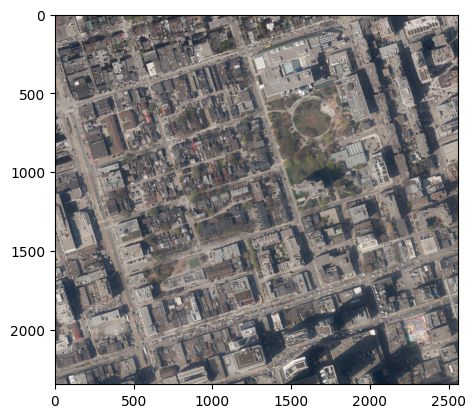

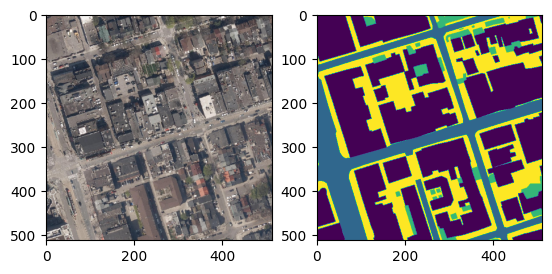

In [47]:
from rasterio.plot import reshape_as_image

# Visualize full image
rasterio.plot.show(full_image)

# Visualize lablled aerial and classes
fig, ax = plt.subplots(1,2)
ax[0].imshow(reshape_as_image(labels_aerial))
ax[1].imshow(labels_classes)

## Data Preparation

### Split Label Image into Patches

In [53]:
# Define patch size and step
patch_size = 128
patch_step = patch_size

In [60]:
from patchify import patchify

# Patchify
patches_classes = patchify(labels_classes, (patch_size, patch_size), step=patch_step)
patches_aerial = patchify(labels_aerial, (3, patch_size, patch_size), step=patch_step)[0]

patches_x, patches_y = patches_classes.shape[0:2]

print(f"Aerial image size: {patches_aerial.shape}")
print(f"Class image size: {patches_classes.shape}")
print(f"Split into {patches_x * patches_y} patches of size {patch_size} x {patch_size}, with step {patch_step}")

Aerial image size: (4, 4, 3, 128, 128)
Class image size: (4, 4, 128, 128)
Split into 16 patches of size 128 x 128, with step 128


#### ***Optional:*** *Visualize patches*

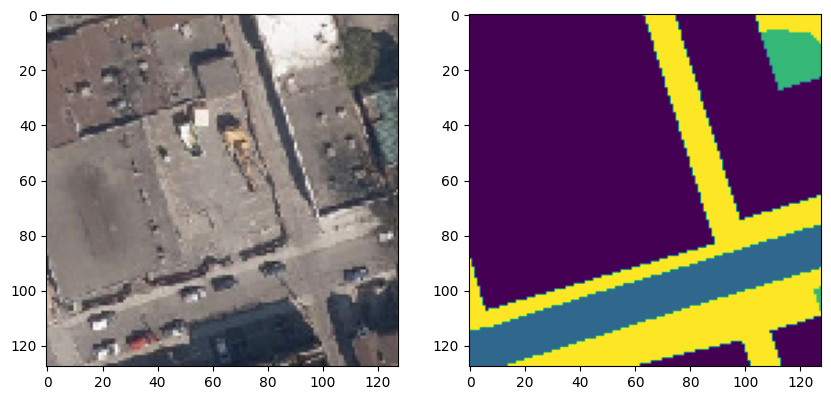

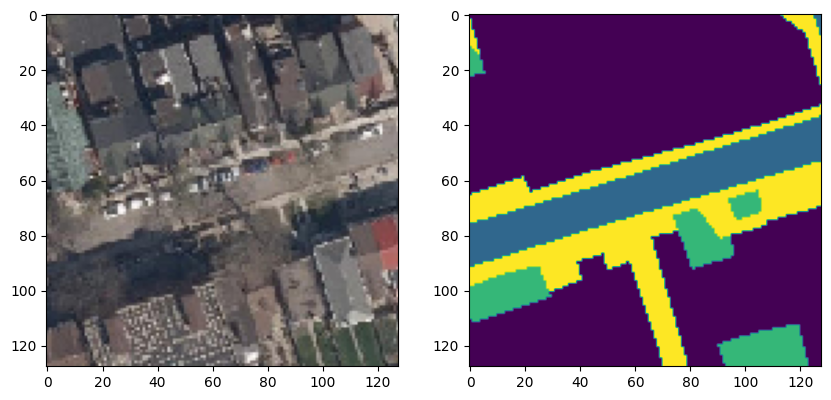

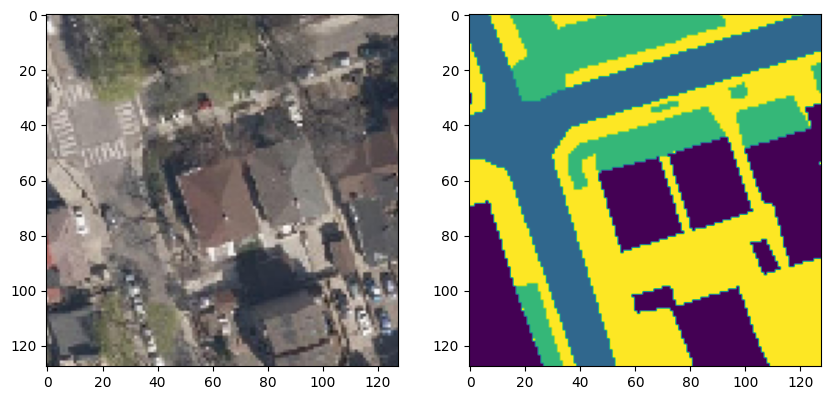

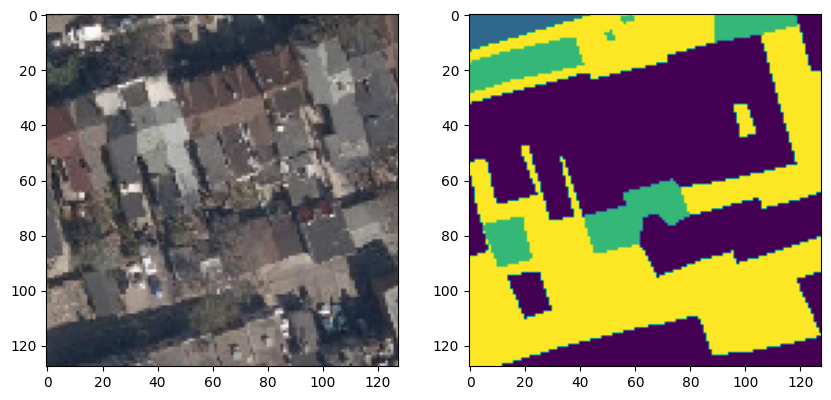

In [57]:
show_x_patches = 4 # How many patches to show (<20 recommended)
show_x_patches = min(show_x_patches, patches_x * patches_y) 
shown = 0

# Visulaize aerial raster and class raster patches next to each other
while shown < show_x_patches:    
    fig, ax = plt.subplots(1, 2, figsize=(10,10))
    
    # Aerial (needs reshape since it has 3 bands)
    ax[0].imshow(
        reshape_as_image(
            patches_aerial[shown // patches_x][shown % patches_y]))
    # Class 
    ax[1].imshow(
        patches_classes[shown // patches_x][shown % patches_y])
    shown += 1

## Prepare Training Data

In [61]:
# Reshape aerial patches (X) - shape (num_patches, 3, patch_size, patch_size)
X = patches_aerial.reshape(-1, 3, patch_size, patch_size)
# Reshape class patches (Y) - shape (num_patches, patch_size, patch_size)
Y = patches_classes.reshape(-1, patch_size, patch_size)
# Print shapes
print(f"X (input) shape: {X.shape}")  # (num_patches, 3, 128, 128)
print(f"Y (labels) shape: {Y.shape}")  # (num_patches, 128, 128)

X (input) shape: (16, 3, 128, 128)
Y (labels) shape: (16, 128, 128)


### Feature Selection

### Split Training and Testing Data

### Fit Classifier


### Evaluate Accuracy

## Predict the Image